<a href="https://colab.research.google.com/github/kumarrishav4/Neuron-Stimulator/blob/main/NeidProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project - Designing a Peripheral Neural Stimulation System
## Problem Definition
Each team will design a neural stimulation system for peripheral nerves in this project. Specifically, the
aim is to use computational modeling to design a magnetic stimulation system for the sciatic nerve.
This involves \
* (1) designing the stimulation coil,
* (2) the circuit to deliver the desired stimulation current
through the coil, and
* (3) optimizing the placement of the coil with respect to the stimulation target
site. In reality, this is a complex project involving several design constraints. However, we are
considering the following assumptions to complete this project in the limited time.
## Assumptions
* The stimulator circuit consists of only a DC voltage source and a capacitor (C = 5 mF).
* Assume a nerve thickness of 0.6 mm. Instead of modeling all the nerve fibers, model only one
nerve fiber at the center of the nerve. The nerve fiber is myelinated with 55 nodes of Ranvier. The
outer and inner diameters of the nerve fiber are 16 and 10 μm, respectively. The distance between
two consecutive nodes is 1.6 mm.
* The simulation domain is considered homogeneous. That is, there is only one type of biological
tissue for the nerve and surrounding space. Therefore, the induced electric field in the nerve can
be calculated using analytical equations instead of complex numerical methods.
## Test Case
Consider a single-turn circular coil, as shown in the figures. The coil's inner diameter is 5 mm. The
minimum separation (along the z-axis) between the nerve and the plane containing the coil is 0.5 mm.
There is an offset of 4 mm along the y-axis between the centers of the nerve and coil. Assume that the
coil is made up of 22 AWG wires. Take an initial value of 400 V for the DC voltage source.

### A) Coil Current for Test Case:
Compute the current i(t) passing through the stimulator coil of the test
case. In the report, include plots of i(t) and time derivative di/dt.

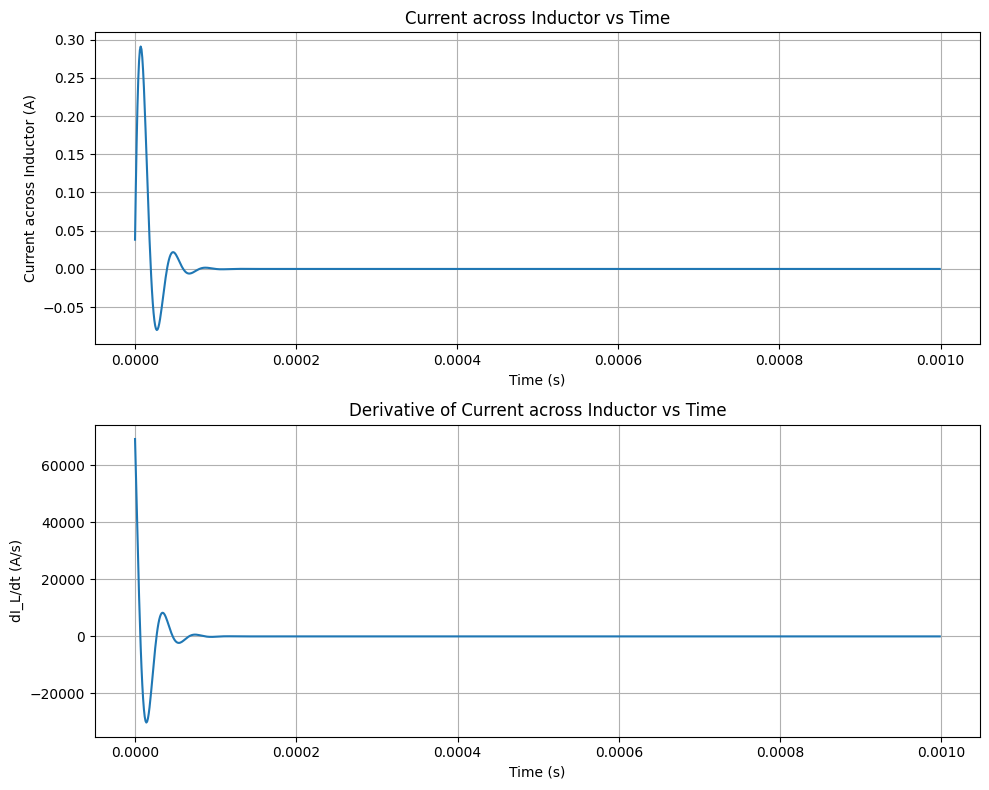

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Circuit parameters
V = 400  # Constant voltage source (Volts)
C = 5*(10**(-3))  # Capacitance (Farads)
L = 7*(10**(-9))  # Inductance (Henries)
R = 0.9*(10**(-3))  # Resistance (Ohms)

# Define the differential equation
def model(y, t):
    dydt1 = y[1]
    dydt2 = V/(L*C) - (R/L)*y[1] - (1/(L*C))*y[0]
    return [dydt1, dydt2]

# Initial conditions
y0 = [0, 0]  # Vc(0) = 0, dVc/dt(0) = 0

# Time vector
t = np.linspace(0, 0.001, 1000)  # Time from 0 to 0.001 seconds

# Solve the differential equation
y = odeint(model, y0, t)

# Extract voltage across the capacitor (Vc)
Vc = y[:, 0]

# Calculate current across the inductor (I_L)
I_L = L * np.diff(Vc) / np.diff(t)

# Calculate derivative of current with respect to time (dI_L/dt)
dI_L_dt = np.diff(I_L) / np.diff(t[1:])

# Plotting
plt.figure(figsize=(10, 8))

# Plot current across the inductor over time
plt.subplot(2, 1, 1)
plt.plot(t[:-1], I_L)
plt.xlabel('Time (s)')
plt.ylabel('Current across Inductor (A)')
plt.title('Current across Inductor vs Time')
plt.grid(True)

# Plot derivative of current with respect to time
plt.subplot(2, 1, 2)
plt.plot(t[:-2], dI_L_dt)
plt.xlabel('Time (s)')
plt.ylabel('dI_L/dt (A/s)')
plt.title('Derivative of Current across Inductor vs Time')
plt.grid(True)

plt.tight_layout()
plt.show()

# Export derivative of current with respect to time to a text file
np.savetxt('dIdt_norm.txt', dI_L_dt, delimiter=',', fmt='%.15f', comments='')


### B. 2D Electric Field for Test Case:
Compute the electric field induced in the proximal nerve for the test case. In the report, include 2D plots of the electric field (Ex component) and electric field gradient (dEx/dx). For these plots, consider the XY plane passing through the nerve center.

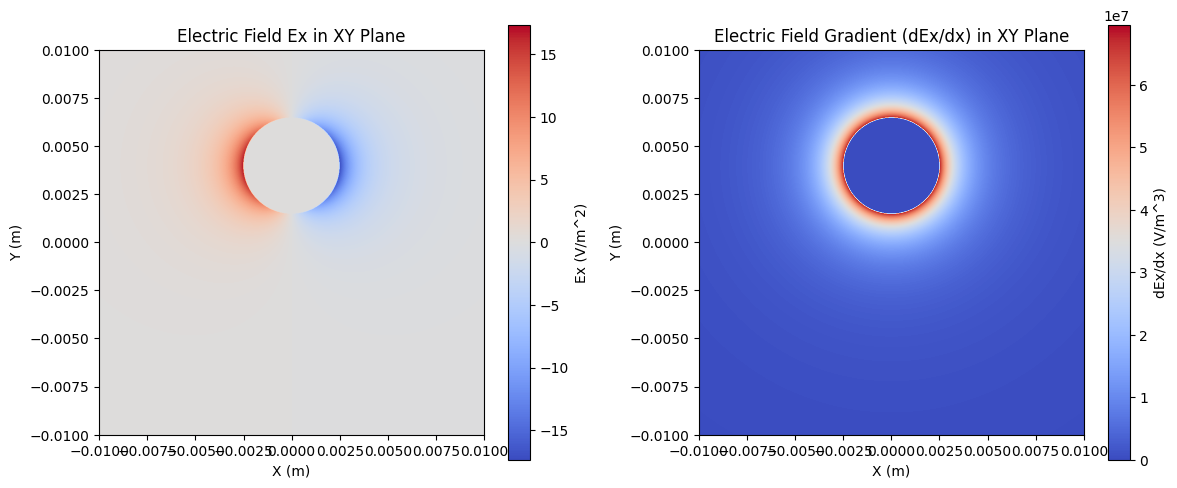

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


mu_0 = 4 * np.pi * 1e-7  # Permeability of free space


coil_inner_diameter = 5.0e-3  # m
nerve_center_offset_y = 4.0e-3  # m
min_separation_z = 0.5e-3  # m

# Define a function to calculate the magnetic field B at a point (x, y, z) due to a circular coil
def magnetic_field(x, y, z, I, coil_diameter):
    r = coil_diameter / 2
    R = np.sqrt(x**2 + y**2)  # radial distance from coil center
    if R <= r:
        return np.array([0.0, 0.0, 0.0])  # Inside the coil, no magnetic field
    else:
        B_z = (mu_0 * I * r**2) / (2 * (R**2 + z**2)**(3/2))
        B_r = (mu_0 * I * r**2 * z) / (2 * (R**2 + z**2)**(3/2))
        return np.array([B_r * x / R, B_r * y / R, B_z])

# Grid parameters for 2D plane passing through nerve center
x_min, x_max = -0.01, 0.01  # Define XY plane limits (m)
y_min, y_max = -0.01, 0.01
num_points = 1000
x_vals = np.linspace(x_min, x_max, num_points)
y_vals = np.linspace(y_min, y_max, num_points)

# Calculate electric field (Ex, Ey) and its gradient (dEx/dx, dEy/dy) in the XY plane
Ex = np.zeros((num_points, num_points))
Ey = np.zeros((num_points, num_points))
dEx_dx = np.zeros((num_points, num_points))
dEy_dy = np.zeros((num_points, num_points))

# Calculate current based on the specific situation
current = 0.29

for i in range(num_points):
    for j in range(num_points):
        x = x_vals[i]
        y = y_vals[j]
        z = min_separation_z  # Fixed z-coordinate at nerve minimum separation
        B_field = magnetic_field(x, y - nerve_center_offset_y, z, current, coil_inner_diameter)
        B_r = B_field[0]  # Radial component of magnetic field
        B_z = B_field[2]  # Axial component of magnetic field
        Ex[j, i] = -B_r / (mu_0 * np.pi * min_separation_z)  # Electric field component Ex (dEx/dx)

        dEx_dx[j, i] = B_z /( mu_0 * np.pi * (min_separation_z)**(2 ))# Electric field gradient dEx/dx
    # print(Ex)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(Ex, cmap='coolwarm', extent=(x_min, x_max, y_min, y_max), origin='lower')
plt.colorbar(label='Ex (V/m^2)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Electric Field Ex in XY Plane')

plt.subplot(1, 2, 2)
plt.imshow(dEx_dx, cmap='coolwarm', extent=(x_min, x_max, y_min, y_max), origin='lower')
plt.colorbar(label='dEx/dx (V/m^3)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Electric Field Gradient (dEx/dx) in XY Plane')

plt.tight_layout()
plt.show()


output_filename = 'dEdx.txt'
np.savetxt(output_filename, dEx_dx, fmt='%.6f', delimiter='\t', newline='\n')
